In [48]:
# 🌐 Computer Vision
import torch
from torch import nn # Neural neutwork components
from torch.utils.data import DataLoader # For batching and loading the data
from torchvision import datasets # To access FashionMNIST
from torchvision.transforms import ToTensor # Convert PIL images to tensors
from torchvision import models

# 🕒 Utilities
from timeit import default_timer as timer # Training time duration
from tqdm import tqdm
import random

# 📊 Visualization and metrics
import matplotlib.pyplot as plt
import torchmetrics
from torchmetrics import Accuracy, ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

In [49]:

from my_functions import (
    get_data_transforms,  # Transformaciones para las imágenes
    get_dataloaders,      # Carga de DataLoaders
    train_step,           # Paso de entrenamiento
    test_step,            # Paso de evaluación
    device,               # Dispositivo (CPU/GPU)
    visualize_predictions # Visualización de predicciones
)

In [50]:
# Obtener transformaciones y DataLoaders
#data_transforms = get_data_transforms(num_channels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data, test_data, train_dataloader, test_dataloader, class_names = get_dataloaders(
    data_dir="../data",
    batch_size=64,
    num_channels=3
)
print(f"Clases: {class_names}")

Clases: ['fractured', 'not fractured']


In [51]:
# Cargar el modelo ResNet50 preentrenado
model = models.resnet50(weights="IMAGENET1K_V1")

# Congelar todas las capas del modelo base
for param in model.parameters():
    param.requires_grad = False

# Reemplazar la última capa para clasificación binaria
# Reemplazar la última capa para clasificación binaria (sin Sigmoid)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Salida binaria


# Mover el modelo al dispositivo
model = model.to(device)


In [52]:
# Configurar el optimizador, la función de pérdida y el scheduler
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=2)
accuracy_metric = torchmetrics.Accuracy(task="binary").to(device)


In [53]:
# Entrenamiento del modelo
train_time_start = timer()
epochs = 10

for epoch in tqdm(range(epochs), desc="Training Progress", unit="epoch"):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Entrenamiento
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, accuracy_metric)
    
    # Evaluación
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, accuracy_metric)
    
    # Ajustar el learning rate
    scheduler.step(test_loss)
    
    # Mostrar resultados del epoch
    print(f"\n\033[1mEpoch {epoch+1}\033[0m:")
    print(f"🔹 Train loss: {train_loss:.4f}, Train accuracy: {train_acc * 100:.0f}%")
    print(f"🔹 Test loss: {test_loss:.4f}, Test accuracy: {test_acc * 100:.0f}%")

train_time_end = timer()
total_train_time = train_time_end - train_time_start
print(f"Total Training Time: {total_train_time:.2f} seconds")

Training Progress:   0%|          | 0/10 [00:00<?, ?epoch/s]


Epoch 1/10


Training Progress:  10%|█         | 1/10 [00:54<08:12, 54.76s/epoch]


Epoch 1:
🔹 Train loss: 0.5188, Train accuracy: 71%
🔹 Test loss: 0.5498, Test accuracy: 70%

Epoch 2/10


Training Progress:  20%|██        | 2/10 [01:48<07:15, 54.43s/epoch]


Epoch 2:
🔹 Train loss: 0.3945, Train accuracy: 82%
🔹 Test loss: 0.4994, Test accuracy: 71%

Epoch 3/10


Training Progress:  30%|███       | 3/10 [02:43<06:20, 54.35s/epoch]


Epoch 3:
🔹 Train loss: 0.3494, Train accuracy: 85%
🔹 Test loss: 0.4596, Test accuracy: 78%

Epoch 4/10


Training Progress:  40%|████      | 4/10 [03:37<05:25, 54.32s/epoch]


Epoch 4:
🔹 Train loss: 0.3315, Train accuracy: 85%
🔹 Test loss: 0.4308, Test accuracy: 78%

Epoch 5/10


Training Progress:  50%|█████     | 5/10 [04:31<04:31, 54.23s/epoch]


Epoch 5:
🔹 Train loss: 0.3016, Train accuracy: 87%
🔹 Test loss: 0.3901, Test accuracy: 81%

Epoch 6/10


Training Progress:  60%|██████    | 6/10 [05:25<03:37, 54.26s/epoch]


Epoch 6:
🔹 Train loss: 0.2859, Train accuracy: 88%
🔹 Test loss: 0.4367, Test accuracy: 76%

Epoch 7/10


Training Progress:  70%|███████   | 7/10 [06:20<02:42, 54.25s/epoch]


Epoch 7:
🔹 Train loss: 0.2857, Train accuracy: 87%
🔹 Test loss: 0.3731, Test accuracy: 81%

Epoch 8/10


Training Progress:  80%|████████  | 8/10 [07:15<01:48, 54.45s/epoch]


Epoch 8:
🔹 Train loss: 0.2657, Train accuracy: 89%
🔹 Test loss: 0.4260, Test accuracy: 77%

Epoch 9/10


Training Progress:  90%|█████████ | 9/10 [08:09<00:54, 54.48s/epoch]


Epoch 9:
🔹 Train loss: 0.2611, Train accuracy: 89%
🔹 Test loss: 0.3795, Test accuracy: 80%

Epoch 10/10


Training Progress: 100%|██████████| 10/10 [09:04<00:00, 54.41s/epoch]


Epoch 10:
🔹 Train loss: 0.2541, Train accuracy: 89%
🔹 Test loss: 0.3624, Test accuracy: 82%
Total Training Time: 544.08 seconds


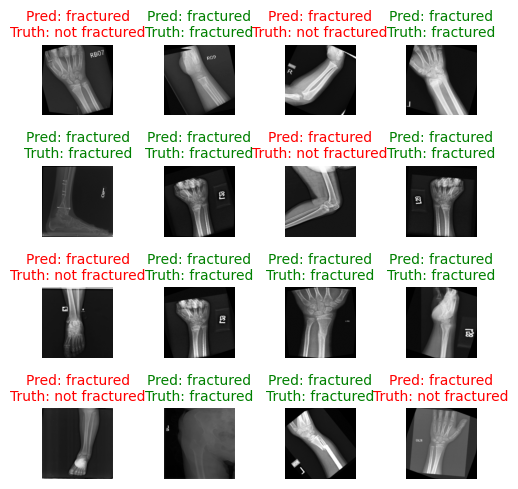

In [54]:
# Visualizar los resultados del modelo
visualize_predictions(
    model=model, 
    test_data=test_data, 
    test_dataloader=test_dataloader, 
    class_names=class_names, 
    device=device
)